# Project 1 - Bayesian Statistical Inference

## Introduction

Spectral lines in discrete absorption or emission spectra are never strictly monochromatic.

Even at very high resolution, one observes a spectral distribution $I(\nu)$ of the absorbed or emitted intensity around the central frequency $\nu_0 = (E_i − E_k)/h$ corresponding to an atomic or molecular transition with energy difference $ΔE = E_i − E_k$ between upper and lower levels. 

The function $I(\nu)$ in the vicinity of $ν_0$ is called the line profile. 

There are several causes for the broadening of spectral lines, some internal to the atom or molecule, others external, and each produces its characteristic profile.

Some types of profile, for example, have a broad core and small wings; others have a narrow core and extensive, broad wings. 

While both natural broadening, due to radiation damping, and pressure broadening give rise to lorentzian line profiles; thermal broadening produces (normalised) gaussian line profiles

$$ G(\nu) = 1 \pm \frac{1}{g} \sqrt{\frac{\ln 2}{\pi}} \exp{\left(- \left[ \frac{\ln 2 (\nu - \nu_0)^2}{g^2} \right]\right)} $$

where the full width at half maximum (FWHM) is equal to $2g$ and proportional to the square root of the temperature of the material responsible for the thermal broadening.

The continuum has been normalized to one, and an emission line corresponds to an addiction to the continuum, while an absorption line corresponds to a subtraction to the continuum. 

Assuming each broadening mechanism acts independently from the others, the observed line profile will be a convolution of the line profiles associated with each mechanism, yielding a Voigt profile. 

However, in what follows, we will assume that thermal broadening clearly dominates over all other line broadening mechanisms, due to prior information that leads us to believe that the observed object has a very high temperature.

## Packages used and general parameters

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from scipy import optimize
import scipy.stats as stats
from scipy.stats import mode
import emcee
import corner
from IPython.display import display, Latex
import time
T0 = time.time()

SMALL_SIZE  = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Question A

Perform the necessary calculations to determine the probability of whether __absorption__ spectral lines, with a gaussian profile and $g = 1$, are present in a given spectrum, taking into account the available data. 

Assume a priori that a __maximum of two absorption spectral lines may be present__ and that no emission line is present. 

The data consists of one dataset containing 201 independent (normalized) flux measurements. 
They can be found in the ASCII table provided. 
The columns (from left to right) have the following meaning:
1. frequency, $\nu$ (in MHz);     
2. the most probable value for the amplitude of the line profile as a function of $\nu$, defined as $G_\mu(\nu)$, after continuum subtraction. 
    
The measurement uncertainty about $G_\mu(\nu)$ should be assumed to be well described by a Gaussian probability distribution

$$ P[G(\nu)] = \frac{1}{\sigma\sqrt{2\pi}} \exp{\left( - \frac{\left[G(\nu) - G_\mu(\nu)\right]^2}{2\sigma^2}  \right)} $$

where $σ$ is equal to 0.02 for all measurements.

--------

I will start by visualizing the data.

After that, I will plot the theoretical lines for one and two thermal absorption lines. These have the same profiles as (normalised) gaussian lines, which can be expressed by $G(\nu)$.

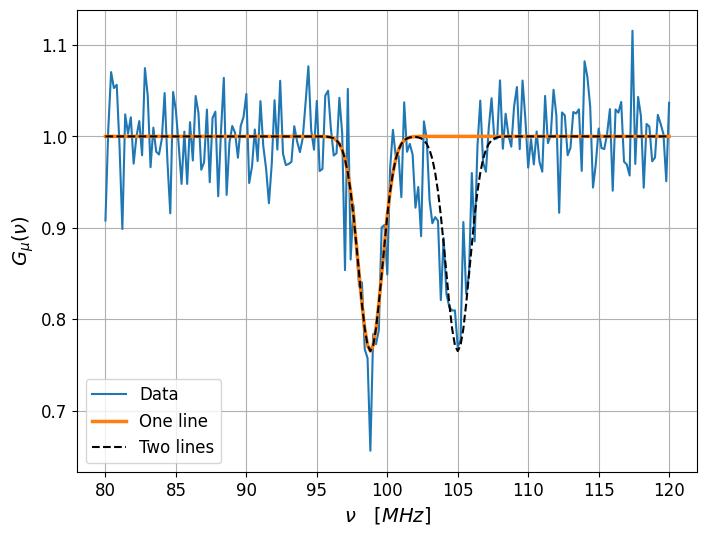

In [18]:
dados = np.loadtxt("data_Tiago_Lourenço.txt", delimiter=" ",skiprows=0)
nu_data = dados[:,0]
Gmu_data = dados[:,1]
sigma = 0.02 # for all mesuraments

nu_0_1 = nu_data[Gmu_data.argmin()] #MHz
nu_0_2 = nu_data[100+(Gmu_data[100:].argmin())] #MHz
# ic(nu_0_1, nu_0_2)
def g1(g,v,v1):
    return 1 - (1 / g * np.sqrt( np.log(2)/np.pi) * np.exp(- ( np.log(2)*(v-v1)**2)/g**2))/2

def g2(g,v,v1,v2):
    return ( (1-1/g*np.sqrt( np.log(2)/np.pi)*np.exp(-(np.log(2)*(v-v1)**2)/g**2)) 
            + (1-1/g*np.sqrt(np.log(2)/np.pi)*np.exp(-( np.log(2)*(v-v2)**2)/g**2)) )/2

plt.figure(figsize=(8,6))
plt.plot(nu_data,Gmu_data,label = "Data")
plt.plot(nu_data, g1(1,nu_data,nu_0_1),       lw=2.5,       label = "One line")
plt.plot(nu_data, g2(1,nu_data,nu_0_1,nu_0_2), "--", c="k", label = "Two lines")
plt.legend()
plt.xlabel(r"$\nu \quad [MHz]$")
plt.ylabel(r"$G_\mu(\nu)$")
plt.grid()
plt.show()

Now that I have a theoretical description of the absorption line profile, I will determine the probability of whether absorption spectral lines, with a gaussian profile and $g = 1$, are present in a given spectrum, taking into account the available data.

For this I assume three principal models:

- Model $M_0$ - where no absorption line is presente and the gaussian line profile is

\begin{equation}
G_0(\nu)=1.
\end{equation}

- Model $M_1$ - which considers the presence of an absorption line whith a frequency of $\nu_0$ and a gaussian line profile given by

\begin{equation}
G_1(\nu) = 1 - \frac{1}{g} \sqrt{\frac{\ln 2}{\pi}} \exp\left\{-\left[ \frac{\ln 2 (\nu - \nu_0)^2}{g^2} \right]\right\}.
\end{equation}

- Model $M_2$ - which considers the presence of two absorption lines whith a frequency of $\nu_1$ and $\nu_2$, and a gaussian line profile given by

\begin{equation}
G_2(\nu) = \left( 1 - \frac{1}{g} \sqrt{\frac{\ln 2}{\pi}} \exp\left\{-\left[ \frac{\ln 2 (\nu - \nu_1)^2}{g^2} \right]\right\} \right)
          + \left(1 - \frac{1}{g} \sqrt{\frac{\ln 2}{\pi}} \exp\left\{-\left[ \frac{\ln 2 (\nu - \nu_2)^2}{g^2} \right]\right\} \right)
\end{equation}

The probability of each of this models is the sum of $P[G_i(\nu)]$ over all frequencies.

For example, in the code below, $P_{21}$ is the array that contains the values of $P[G_2(\nu)]$ for different values of $\nu$.
After having the array of probabilities $P_{21}$ I just need to add all the values in this array and will have the probability of obtaining Model 2. Which is the probability of existing 2 absorption lines in the data.

In [19]:
def func_PG(G_i, G_mu, sigma):
	return 1/(sigma*np.sqrt(2*np.pi)) * np.exp( - np.sum((G_i - G_mu)**2 / (2*sigma**2)))

def prob(nu,Gmu,g,sigma, model):
    N = len(nu)
    if model == "0":
        P = np.zeros(N, dtype = np.longfloat)
        for i in range(len(nu)):
            G_0 = 1
            P[i]= func_PG(G_0, Gmu, sigma )

    if model == "1":
        P = np.zeros(N, dtype = np.longfloat)
        for i in range(N):
            G_1 = g1(g,nu,nu[i])
            P[i]= func_PG(G_1, Gmu, sigma )            
            
    if model == "2":
        P = np.zeros((N,N), dtype = np.longfloat)
        for i in range(N):
            for j in range(N):
                G_2 = g2(g,nu, nu[i], nu[j])
                P[i,j]= func_PG(G_2, Gmu, sigma )
    
    return  P

P01 = prob(nu_data,Gmu_data,1,sigma, "0")
P11 = prob(nu_data,Gmu_data,1,sigma, "1")
P21 = prob(nu_data,Gmu_data,1,sigma, "2")

# Normalizing the probabilities
total_posterior = np.sum(P01)+np.sum(P11)+np.sum(P21)
if total_posterior != 0:
    prob_0 = np.sum(P01) / total_posterior 
    prob_1 = np.sum(P11) / total_posterior 
    prob_2 = np.sum(P21) / total_posterior
else:
    prob_0 = 0.0
    prob_1 = 0.0
    prob_2 = 0.0 

print("Probability of no absorption lines:", prob_0)
print("Probability of one absorption line:", prob_1)
print("Probability of two absorption lines:", prob_2)

Probability of no absorption lines: 0.0
Probability of one absorption line: 0.0
Probability of two absorption lines: 1.0


## Question B

Assume now _a priori_ that two absorption spectral lines are present. 

1. Plot the joint posterior probability distribution for both $\nu_0$. 
2. Plot the marginal posterior probability distribution for each $\nu_0$. 
3. Determine the mode, median, mean and the smallest interval in $\nu_0$ that contains $95\%$ of the posterior probability, for both spectral lines.
4. Finally, make a plot that includes the values observed for $G(\nu)$, including the uncertainty associated with each point, as a function of the frequency, $\nu$, as well as the theoretically expected values for $G(\nu)$, assuming the values for the $\nu_0$ corresponding to each absorption line are equal to the values associated with the mode of the joint posterior distribution of both $\nu_0$.

### B.1 )  Joint Posterior Probability for both lines 

The Joint Posterior Probability of both lines is the posterior probability measured previously for Model 2, which is the 2D array $P_{21}$ 

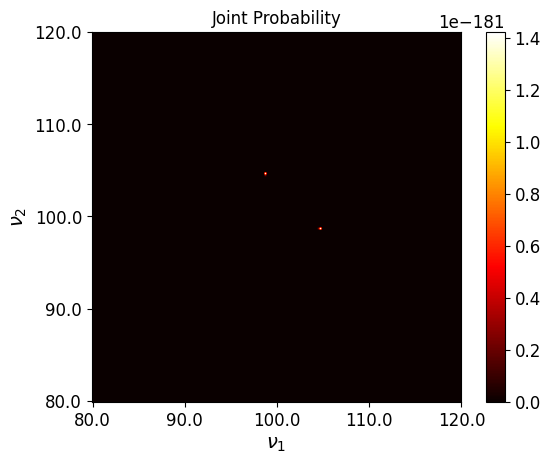

In [20]:
plt.imshow(P21, cmap = "hot", origin = "lower" )
plt.colorbar()
plt.yticks(np.linspace(0,201,5),np.round(np.linspace(nu_data[0],nu_data[-1],5), decimals = 0))
plt.xticks(np.linspace(0,201,5),np.round(np.linspace(nu_data[0],nu_data[-1],5), decimals = 0))
plt.xlabel(r"$\nu_1$")
plt.ylabel(r"$\nu_2$")
plt.title("Joint Probability")
plt.show()

### B.2 ) Marginal Posterior Probability Distribution for both lines 

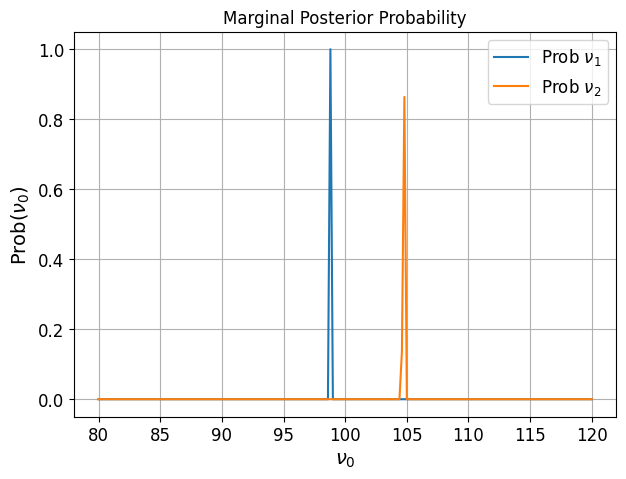

In [21]:
def posterior_joint(v, G_mu, g, Sig):
    prob_nu0 = np.ones((len(v), len(v))) 
    for i, nu_0_1 in enumerate(v):
        for j, nu_0_2 in enumerate(v[:i]):
            G_absorption_1 = g1(g,v,nu_0_1)
            G_absorption_2 = g1(g,v,nu_0_2)
            likelihood = np.prod(stats.norm.pdf(G_mu, loc=G_absorption_1+G_absorption_2-1, scale=Sig))
            prob_nu0[i, j] *= likelihood
    
    return prob_nu0 / np.sum(prob_nu0)

# Joint posterior probability distribution for nu_0
joint_posterior = posterior_joint(nu_data, Gmu_data, 1, sigma)

P12_j = np.sum(joint_posterior,axis = 0) 
P22_j = np.sum(joint_posterior,axis = 1) 

plt.figure(figsize=(7,5))
plt.plot(nu_data, P12_j, label = r"Prob $\nu_1$")
plt.plot(nu_data, P22_j, label = r"Prob $\nu_2$")
plt.legend()
plt.xlabel(r"$\nu_0$")
plt.ylabel(r"Prob$(\nu_0)$")
plt.title("Marginal Posterior Probability")
plt.grid()
plt.show()

### B.3 )  Mode, Median, Mean, Smallest interval in $\nu_0$ that contains $95\%$ of the posterior probability.

In [22]:
total_prob = np.sum(P21)
print(F"Total probability: {total_prob:.3e}")
print(F"Max value: {np.max(P21):.3e}")
print()
print(F"Total probability normalized: {np.sum(P21)/total_prob:.3f}")
print(F"Max value normalized: {np.max(P21)/total_prob:.3f}")

# Parte feita para encontrar os nus com prob maximas
m = np.max(P21)
ind_i = 0
ind_j = 0
for i in range(len(P21[0,:])):
    for j in range(len(P21[:,0])):
        if P21[i,j] == m:
            ind_i = j
            ind_j = i
 
# Nesta secção já sabiamos qual os vs e fizemos em função disso
u,a,b = 0,0,0

while u < 0.95*total_prob:
    u=0
    AA = P21[ind_i-a:ind_i+a , ind_j-b:ind_j+b]
    u = np.sum(AA)
    if a == b:
        a+= 1
    elif a > b: 
        b+= 1
# Os valores encontrados foram a=b=6 mas nesse caso ficava mais de 95%, por isso decidi fazer menos
print("-----------------")
display(Latex(rF"For Max value: $\nu_1 = {ind_i}$, $\nu_2={ind_j}$"))
display(Latex(rF"Smallest interval containing 95% of the posterior probability: $\nu_1 \in [{ind_i-a},{ind_i+a}]$ and $\nu_1 \in [{ind_j-b},{ind_j+b}]$ "))

print("----------------------")
MM = np.sum(P21[ind_i-a:ind_i+a , ind_j-b:ind_j+b])
print(F"95% of max value: {total_prob*0.95:.3e}")
print(F"Sum of value for region found: {MM:.3e}")
print()
print(F"95% of max value normalized: {total_prob*0.95/total_prob:.3f}")
print(F"Sum of value for region found normalized: {(MM/total_prob):.3f}")
 
print("---------------")
display(Latex(r"For $G(\nu)$"))
print(F"Median P: {np.median(Gmu_data):.3f}")
print(F"Mode P:   {mode(Gmu_data)[0]:.3f}")
print(F"Mean P:   {np.mean(Gmu_data):.3f}") 

Total probability: 3.295e-181
Max value: 1.423e-181

Total probability normalized: 1.000
Max value normalized: 0.432
-----------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

----------------------
95% of max value: 3.130e-181
Sum of value for region found: 3.295e-181

95% of max value normalized: 0.950
Sum of value for region found normalized: 1.000
---------------


<IPython.core.display.Latex object>

Median P: 0.987
Mode P:   0.656
Mean P:   0.975


### B.4 )  Plot

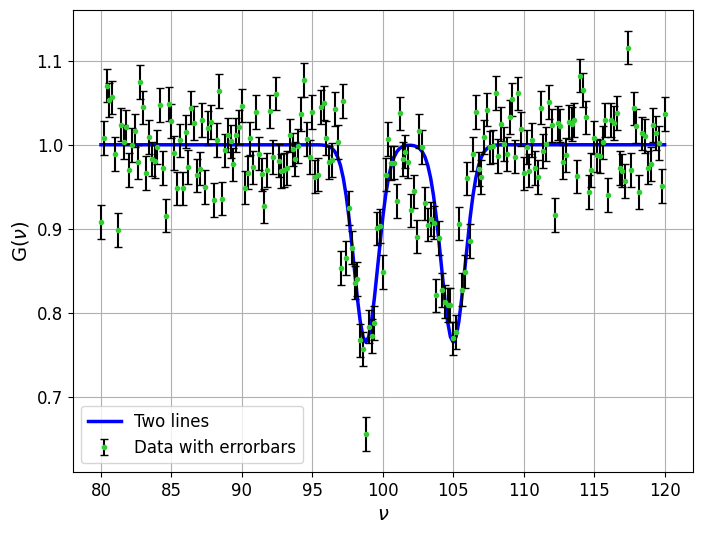

In [23]:
plt.figure(figsize=(8,6))
plt.plot(nu_data, g2(1,nu_data,nu_0_1,nu_0_2),lw=2.5,c="b", label = "Two lines")
plt.errorbar(nu_data,Gmu_data, yerr = sigma, fmt=".", color="limegreen", ecolor="k", capsize=2.7, label="Data with errorbars")
plt.legend()
plt.xlabel(r"$\nu$")
plt.ylabel(r"G($\nu$)")
plt.grid()
plt.show()

## Question C

Perform again the necessary calculations to determine the probability of whether __absorption__ spectral lines, with a gaussian profile, are present in a given spectrum given the available data. 
But now use the output of Monte Carlo Markov Chains to perform such calculations. 
Continue to assume a priori that a maximum of two absorption spectral lines may be present and that no emission line is present. 
But assume now that the value of $g$ is unknown _a priori_. 

Then, assuming a priori that two __absorption__ spectral lines are present, determine and plot the (2D) joint and (1D) marginal posterior probability distributions for all model parameters. 

Characterize them by determining their modes, medians, means, and the smallest intervals in $g$ and both $\nu_0$ that contain 95% of the associated marginal posterior probability.

-----

To obtain a good estimation of the value of $g$, I will use the packages "emcee" and "corner". 

In [24]:
def model(theta,v):
    v1,v2,g = theta
    return g2(g,v,v1,v2)

def lnlike(theta, x, y, yerr):
    g,v1,v2 = theta
    model = g2(g,nu_data,v1,v2)  # Calculate the model RV values
    like = -0.5 * np.sum(((y - model)/yerr) ** 2)
    return like

def lnprior(theta):
    g,v1,v2 = theta
    if 0 < g < 2 and  0. < v1 < 1e100 and v1 < v2 < 1e100:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp): #check if lp is infinite:
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

In [25]:
def main(p0,nwalkers,nsteps,ndim,lnprob,data): 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, nsteps)

    return sampler, pos, prob, state

In [26]:
data = (nu_data, Gmu_data, sigma) 
nwalkers = 1000                     #set nwalkers
nsteps = 1000  
g = 1
v1 = nu_0_1      
v2 = nu_0_2     

initial = np.array([g,v1,v2])        #initial guess
ndim = len(initial)
p0 = [initial + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler, pos, prob, state = main(p0,nwalkers,nsteps,ndim,lnprob,data)

samples = sampler.flatchain
theta_max  = samples[np.argmax(sampler.flatlnprobability)]

Running burn-in...


  8%|▊         | 8/100 [00:00<00:06, 14.99it/s]

100%|██████████| 100/100 [00:05<00:00, 17.04it/s]


Running production...


Now that I have the estimstions let's visualize them.

The best fit values are: g = 1.032, $\nu_1$ = 98.767, $\nu_2$ = 104.711


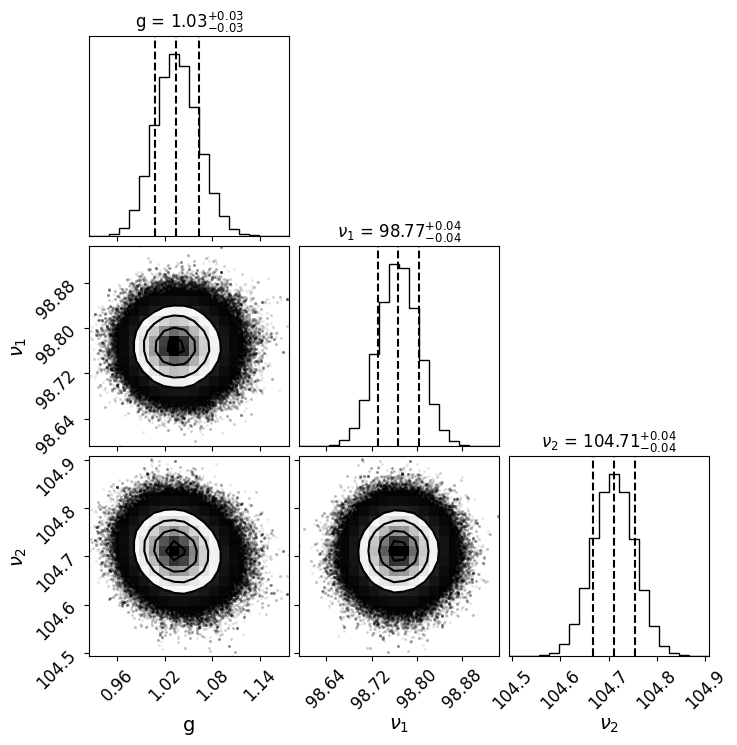

In [27]:
g_val, nu_1_val, nu_2_val = theta_max 

print(rF'The best fit values are: g = {g_val:.3f}, $\nu_1$ = {nu_1_val:.3f}, $\nu_2$ = {nu_2_val:.3f}')

labels = ['g',r'$ν_1$',r'$ν_2$']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

I now have the values of $g$, $\nu_1$ and $\nu_2$ estimated through the MCMC method. The only thing left to do is to do again all the analysis that was done before for this new values.

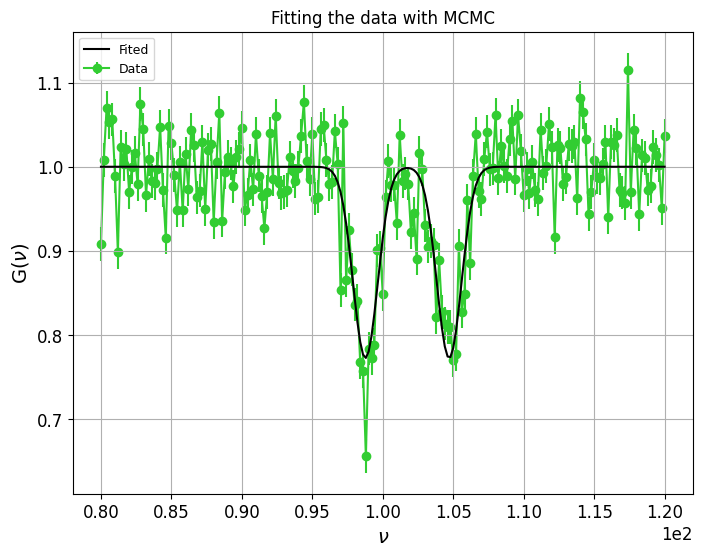

In [28]:
best_fit_model = g2(g_val, nu_data, nu_1_val, nu_2_val)

plt.figure(figsize=(8,6))
plt.grid()
plt.plot(nu_data,best_fit_model,color = "k",label='Fited', zorder=2)
plt.errorbar(nu_data, Gmu_data, yerr=sigma, fmt='-o', color='limegreen',label='Data', zorder=1)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("$ν$")
plt.ylabel("G($ν$)")
plt.title("Fitting the data with MCMC")
plt.legend(loc="best",fontsize="9")
plt.show()

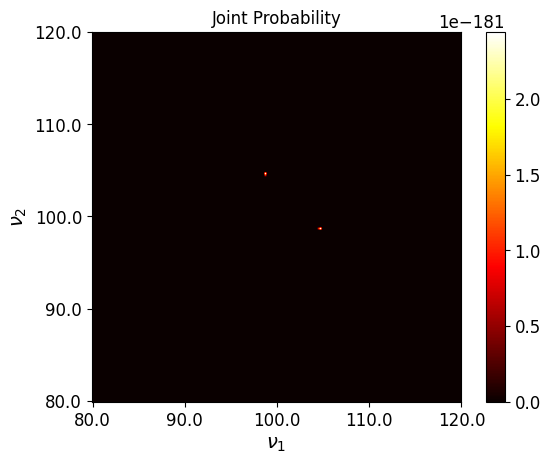

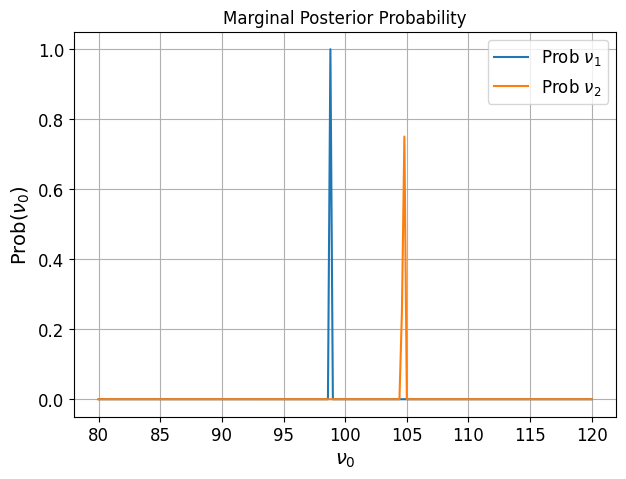

Total probability: 6.511e-181
Max value: 2.443e-181

Total probability normalized: 1.000
Max value normalized: 0.375
-----------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

----------------------
95% of max value: 6.185e-181
Sum of value for region found: 6.511e-181

95% of max value normalized: 0.950
Sum of value for region found normalized: 1.000
---------------


<IPython.core.display.Latex object>

Median P: 0.987
Mode P:   0.656
Mean P:   0.975


In [29]:
def func_PG(G_i, G_mu, sigma):
	return 1/(sigma*np.sqrt(2*np.pi)) * np.exp( - np.sum((G_i - G_mu)**2 / (2*sigma**2)))

def prob(nu,Gmu,g,sigma, model):
    N = len(nu)
    if model == "0":
        P = np.zeros(N, dtype = np.longfloat)
        for i in range(len(nu)):
            G_0 = 1
            P[i]= func_PG(G_0, Gmu, sigma )

    if model == "1":
        P = np.zeros(N, dtype = np.longfloat)
        for i in range(N):
            G_1 = g1(g,nu,nu[i])
            P[i]= func_PG(G_1, Gmu, sigma )            
            
    if model == "2":
        P = np.zeros((N,N), dtype = np.longfloat)
        for i in range(N):
            for j in range(N):
                G_2 = g2(g,nu,nu[i], nu[j])
                P[i,j]= func_PG(G_2, Gmu, sigma )
    
    return  P


P21_MCMC = prob(nu_data,Gmu_data, g_val, sigma, "2")

plt.imshow(P21_MCMC, cmap = "hot", origin = "lower" )
plt.colorbar()
plt.yticks(np.linspace(0,201,5),np.round(np.linspace(nu_data[0],nu_data[-1],5), decimals = 0))
plt.xticks(np.linspace(0,201,5),np.round(np.linspace(nu_data[0],nu_data[-1],5), decimals = 0))
plt.xlabel(r"$\nu_1$")
plt.ylabel(r"$\nu_2$")
plt.title("Joint Probability")
plt.show()

# Joint posterior probability distribution for nu_0
joint_posterior_MCMC = posterior_joint(nu_data, Gmu_data, g_val, sigma)

P12_j_MCMC = np.sum(joint_posterior_MCMC,axis = 0) 
P22_j_MCMC = np.sum(joint_posterior_MCMC,axis = 1) 

plt.figure(figsize=(7,5))
plt.plot(nu_data, P12_j_MCMC, label = r"Prob $\nu_1$")
plt.plot(nu_data, P22_j_MCMC, label = r"Prob $\nu_2$")
plt.legend()
plt.xlabel(r"$\nu_0$")
plt.ylabel(r"Prob$(\nu_0)$")
plt.title("Marginal Posterior Probability")
plt.grid()
plt.show()



total_prob = np.sum(P21_MCMC)
print(F"Total probability: {total_prob:.3e}")
print(F"Max value: {np.max(P21_MCMC):.3e}")
print()
print(F"Total probability normalized: {np.sum(P21_MCMC)/total_prob:.3f}")
print(F"Max value normalized: {np.max(P21_MCMC)/total_prob:.3f}")

m = np.max(P21_MCMC)
ind_i = 0
ind_j = 0
for i in range(len(P21_MCMC[0,:])):
    for j in range(len(P21_MCMC[:,0])):
        if P21_MCMC[i,j] == m:
            ind_i = j
            ind_j = i
 
u,a,b = 0,0,0

while u < 0.95*total_prob:
    u=0
    AA = P21_MCMC[ind_i-a:ind_i+a , ind_j-b:ind_j+b]
    u = np.sum(AA)
    if a == b:
        a+= 1
    elif a > b: 
        b+= 1

print("-----------------")
display(Latex(rF"For Max value: $\nu_1 = {ind_i}$, $\nu_2={ind_j}$"))
display(Latex(rF"Smallest interval containing 95% of the posterior probability: $\nu_1 \in [{ind_i-a},{ind_i+a}]$ and $\nu_1 \in [{ind_j-b},{ind_j+b}]$ "))

print("----------------------")
MM = np.sum(P21_MCMC[ind_i-a:ind_i+a , ind_j-b:ind_j+b])
print(F"95% of max value: {total_prob*0.95:.3e}")
print(F"Sum of value for region found: {MM:.3e}")
print()
print(F"95% of max value normalized: {total_prob*0.95/total_prob:.3f}")
print(F"Sum of value for region found normalized: {(MM/total_prob):.3f}")
 
print("---------------")
display(Latex(r"For $G(\nu)$"))
print(F"Median P: {np.median(Gmu_data):.3f}")
print(F"Mode P:   {mode(Gmu_data)[0]:.3f}")
print(F"Mean P:   {np.mean(Gmu_data):.3f}") 


In this question I used the MCMC method to obtain the best estimation of the values of $g, \nu_1$ and $\nu_2$. 

The values obtained: $g = 1.03\pm0.03$, $\nu_1 = 98.77\pm0.04$ and $\nu_2 = 104.71\pm0.04$ were slightly different from the previous values used for this parameters, however they still reproduced the same results.

So, I conclude that the assumptions made on the previous models, questions A and B, were correct.

## Time

In [30]:
#################################### Tempo total que o programa demora a correr ############################################
t1=time.time()
print("This notebook takes {} min and {} seconds to run.".format((t1-T0)//60,int((t1-T0)%60)))

This whole notebook takes 1.0 min and 23 seconds to run.
